## University of Bari Aldo Moro
<a name="top"></a>
Master Degree in <b>Computer Science</b> - <b>Computer Vision Course</b><br>

### Vision Transformer for Unmanned Aerial Vehicles Agronomic Research
- [Dependencies](#dependencies)
- [Paths](#paths)
- [Parameters](#parameters)
- [Preprocessing](#preprocessing)
    - [Ground Truth](#ground-truth)
    - [GCP Finder](#gcp_finder)
    - [Plots Clipper](#plots_clipper)
- [Dataset](#dataset)
- [Model](#model)
    - [Training](#training)
    - [Evaluation](#evaluation)
    - [Inference](#inference)

### Dependencies
<a name='dependencies'></a>
[toTop](#top)

In [7]:
# Libraries

from argparse import ArgumentParser
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateFinder
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models import get_model, ViT_B_32_Weights, ViT_B_16_Weights, ViT_L_16_Weights, ViT_H_14_Weights
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import mlflow.pytorch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
print(torch.__version__)

2.0.0+cu117


In [8]:
# Import from notebooks

import import_ipynb

from notebooks.gcp_finder import GCPFinder
from notebooks.clipper import Clipper
from notebooks.dataset import BaseDataset, PlotsDataset
from notebooks.vit import UAV_vit
from notebooks.visualization import Visualization

In [9]:
# Cuda setup

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used", device)
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead", device)

GPU is available and being used cuda


#### Paths
<a name="paths"></a>
[toTop](#top)

In [10]:
# Paths

DATASET_PATH = "./data/dataset"
PLOT_PATH = "./data/plots"
SAMPLES_PATH = "./data/raw_samples"
VISUALS_PATH = "./data/visuals"
SHAPEFILE_PATH = "./data/shapefile/all_plots.shp"
ORTHOMOSAIC_PATH = "./data/orthomosaic/raster.tif"
GCP_PATH = "./data/GCP_Images"
GROUND_TRUTH_PATH = './data/ground_truth/corn_plant_height_ground_truth.xlsx'
MODEL_PATH = "./data/models/"
CHECKPOINT_PATH = "./data/checkpoints/"

### Parameters
<a name='parameters'></a>
[toTop](#top)

In [11]:
# Parameters

TEST_SIZE = 0.2 # % of dataset
VAL_SIZE = 0.2  # % of training set

MAX_EPOCS = -1
BATCH_SIZE = 8
WORKERS = 8
IMG_SIZE = (224,224)

BACKBONES = [
    {'name': "vit_b_16", 'weights': ViT_B_16_Weights.DEFAULT}, # default ImageNet on DeIT recipe
    {'name': "vit_b_16", 'weights': ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1},
    {'name': "vit_b_32", 'weights': ViT_B_32_Weights.DEFAULT},
    {'name': "vit_l_16", 'weights': ViT_L_16_Weights.DEFAULT}, # recipe https://github.com/pytorch/vision/tree/main/references/classification#vit_l_16
    {'name': "vit_l_16", 'weights': ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1},
    {'name': "vit_l_32", 'weights': ViT_L_16_Weights.DEFAULT},
    {'name': "vit_h_14", 'weights': ViT_H_14_Weights.IMAGENET1K_SWAG_LINEAR_V1},
]
BACKBONE = BACKBONES[7]

FROZEN_LAYERS = 6

ES_PATIENCE = 20
ES_STOPPING_THRESHOLD = 1e-5
ES_DIVERGENCE_THRESHOLD = 5

LR_FINDER = False
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-1
DROPOUT = 0.2
ATTENTION_DROPOUT = 0.2

## Preprocessing
<a name='preprocessing'></a>
[toTop](#top)

#### Ground truth
<a name="ground_truth"></a>
[toTop](#top)

In [15]:
# Loading the ground truth
df = pd.read_excel(GROUND_TRUTH_PATH)
df[['DataFile 3', 'PHT(m)', 'Elev maximum (m)']].head()

,DataFile 3,PHT(m),Elev maximum (m)
0,2A2B_1.las,2.1590,2.80
1,2A2B_2.las,2.1590,2.86
2,2A2B_3.las,2.1336,2.69
3,2A2B_4.las,2.3622,2.64
4,2A2B_5.las,2.0574,2.65


In [16]:
# Ground Truth Preprocessing

def renaming(filename):
    return filename[:-4] + ".png"

def elev_avg(row):
    return (row['PHT(m)'] + row["Elev maximum (m)"]) / 2

# Apply renaming and averaging
df["filename"] = df["DataFile 3"].apply(renaming)
df["elevation_avg"] = (df.apply(elev_avg, axis=1))

# Elevation format conversion to float32
df["elevation_avg"] = df["elevation_avg"].astype(np.float32)
df[['filename', 'elevation_avg']].head()

,filename,elevation_avg
0,2A2B_1.png,2.4795
1,2A2B_2.png,2.5095
2,2A2B_3.png,2.4118
3,2A2B_4.png,2.5011
4,2A2B_5.png,2.3537


In [17]:
# Targets normalization

scaler = MinMaxScaler()
df["elevation"] = scaler.fit_transform(df[["elevation_avg"]])

In [18]:
# Scaled targets

df[["filename", "elevation"]].head()

,filename,elevation
0,2A2B_1.png,0.597696
1,2A2B_2.png,0.618148
2,2A2B_3.png,0.551541
3,2A2B_4.png,0.612422
4,2A2B_5.png,0.511931


#### Ground Control Point (GCP) Finder
<a name='gcp_finder'></a>
[toTop](#top)

In [19]:
# gcp_finder = GCPFinder(DATASET_PATH, GCP_PATH)
# gcp_finder.gcp_mover()

#### Plots Clipper
<a name='plots_clipper'></a>
[toTop](#top)

In [20]:
# clipper = Clipper(ORTHOMOSAIC_PATH, SHAPEFILE_PATH, PLOT_PATH)
# clipper.start()

## Dataset
<a name="dataset"></a>
[toTop](#top)

In [22]:
# Datasets definition

dataset = PlotsDataset(labels=df[["filename", "elevation"]], img_dir=PLOT_PATH, img_size=IMG_SIZE)

print(f"Dataset length: {len(dataset)}")
print(f"Image type: {type(dataset[0][0])}")
print(f"Image shape: {dataset[0][0].shape})")
print(f"Label type: {type(dataset[0][1])}")

Dataset length: 705
Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224]))
Label type: <class 'numpy.float32'>


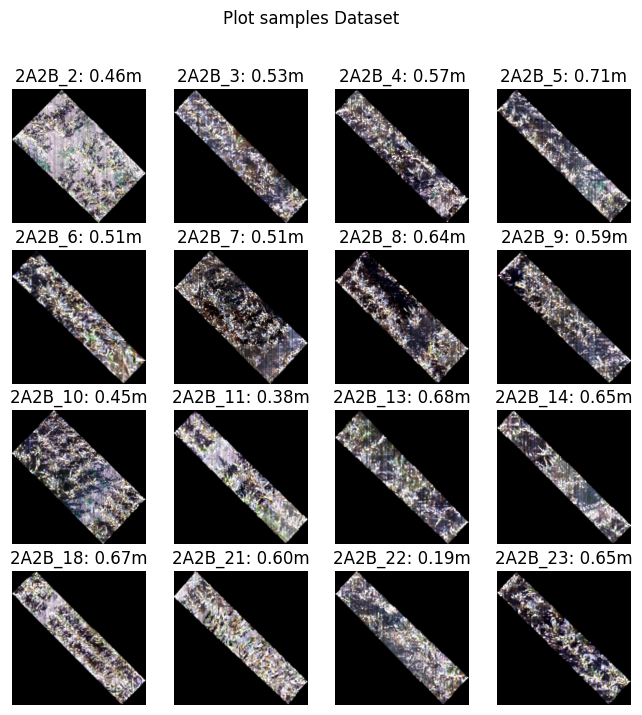

In [23]:
# Dataset samples

dataset.show_samples(df['elevation'], "Dataset")

Text(0.5, 1.0, 'Distribution of pixels')

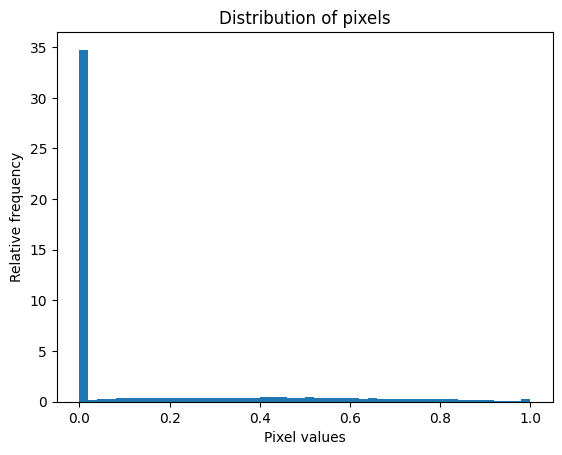

In [24]:
# Pixel distribution

plt.hist(dataset[0][0].permute(1,2,0).ravel(), bins=50, density=True)
plt.xlabel("Pixel values")
plt.ylabel("Relative frequency")
plt.title("Distribution of pixels")

In [25]:
# Datasets means and stds

means, stds = dataset.get_means_stds()
print(f'Dataset means: {means}\nstds: {stds}')

Dataset means: [0.16963925957679749, 0.16202490031719208, 0.165080264210701]
stds: [0.27799004316329956, 0.2698167860507965, 0.27221810817718506]


In [26]:
# Dataset split

train_set, test_set = train_test_split(dataset, test_size=TEST_SIZE)
train_set, val_set = train_test_split(train_set, test_size=VAL_SIZE)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 451
Validation set size: 113
Test set size: 141


In [27]:
# Dataloaders

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=WORKERS)

print(f"Train Dataloader size: {len(train_loader)}")
print(f"Validation Dataloader size: {len(val_loader)}")
print(f"Test Dataloader size: {len(test_loader)}")

Train Dataloader size: 57
Validation Dataloader size: 15
Test Dataloader size: 18


## Model
<a name='model'></a>
[toTop](#top)

In [28]:
# Backbone

backbone = get_model(BACKBONE['name'], weights=BACKBONE['weights'])
backbone.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [29]:
# Vargs setup

def setup_vargs(lr = LEARNING_RATE):
    parser = ArgumentParser()
    parser.add_argument('--learning_rate', type=float, default=lr)
    parser.add_argument('--weight_decay', type=float, default=WEIGHT_DECAY)
    parser.add_argument('--batch_size', type=int, default=BATCH_SIZE)
    parser.add_argument('--no_grad_layers_n', type=int, default=FROZEN_LAYERS)
    parser.add_argument('--dropout', type=float, default=DROPOUT)
    parser.add_argument('--attention_dropout', type=float, default=ATTENTION_DROPOUT)

    args, _ = parser.parse_known_args()

    vargs = vars(args)
    return vargs

vargs = setup_vargs()

In [30]:
# MLFlow init

mlflow.pytorch.autolog() 
mlflow.start_run()

run = mlflow.active_run()
log_run_id = run.info.run_id
print(f"Active run_id: {run.info.run_id}")

Active run_id: 9a3255b8cda741ce9b32a9b0bb941048


In [31]:
# Model

model = UAV_vit(backbone, **vargs)

In [32]:
model.backbone.heads

Sequential(
  (head): Linear(in_features=768, out_features=1, bias=True)
)

### Training
<a name='training'></a>
[toTop](#top)

In [33]:
# Callbacks

learning_rate_finder_cb = LearningRateFinder(num_training_steps=200)
checkpoint_cb = ModelCheckpoint(dirpath=CHECKPOINT_PATH, save_top_k=1, monitor="val_loss", mode="min", filename="uav_vit-{epoch:02d}-{val_loss:.3f}")
earlyStopping_cb = EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, stopping_threshold=ES_STOPPING_THRESHOLD, divergence_threshold=ES_DIVERGENCE_THRESHOLD, mode="min")

callbacks = [earlyStopping_cb, checkpoint_cb]
if LR_FINDER:
    callbacks.append(learning_rate_finder_cb)

In [34]:
# Trainer

trainer = pl.Trainer(
    max_epochs=MAX_EPOCS,
    callbacks=callbacks,
    num_sanity_val_steps=0,
    enable_checkpointing=True,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [35]:
# Fit

trainer.fit(model, train_loader, val_loader)

d:\Repository\UAV_ViT\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\Repository\UAV_ViT\data\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params
---------------------------------------------------
0 | backbone     | VisionTransformer | 85.8 M
1 | criterion    | LogCoshError      | 0     
2 | val_metrics  | MetricCollection  | 0     
3 | test_metrics | MetricCollection  | 0     
---------------------------------------------------
80.9 M    Trainable params
4.9 M     Non-trainable params
85.8 M    Total params
343.198   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
LR_FOUND = True if 'suggested_lr' in globals() else False
if LR_FOUND:
    suggested_lr = learning_rate_finder_cb.optimal_lr.suggestion()
    learning_rate_finder_cb.optimal_lr.plot(suggest=True, show=True)

### Testing
<a name='testing'></a>
[toTop](#top)

In [ ]:
# Best model path

checkpoint_cb.best_model_path

In [ ]:
# Load best model

vargs = setup_vargs(suggested_lr) if LR_FOUND else setup_vargs()
model = UAV_vit.load_from_checkpoint(checkpoint_cb.best_model_path, backbone=backbone, **vargs)

In [ ]:
# Test best model

trainer.test(model, test_loader)

In [ ]:
# Extract test results

outputs = model.test_output
test_loss = model.test_loss
test_targets_mean = model.test_targets_mean
test_targets = [x[1] for x in test_set]

residuals = []
for lab, out in zip(test_targets, outputs):
    residuals.append(lab - out)

In [ ]:
# R2 score

r2 = r2_score(test_targets, outputs)
print(f"R2 score: {r2}")

### Inference
<a name='inference'></a>
[toTop](#top)

In [ ]:
visuals = Visualization(VISUALS_PATH, log_run_id)

In [ ]:
visuals.plot_residuals(residuals)

In [ ]:
visuals.plot_residuals_vs_outputs(residuals, outputs)

In [ ]:
visuals.plot_residuals_errors(residuals)

In [ ]:
visuals.plot_targets_means_vs_losses(test_targets_mean, test_loss)

In [ ]:
visuals.plot_outputs_vs_targets(outputs, test_targets)

In [ ]:
# Log parameters

mlflow.log_params({
    "model": BACKBONE['name'],
    "weights": BACKBONE['weights'],
    "R2Score": r2,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "train_epochs": MAX_EPOCS,
    "run_id": log_run_id,
    "path": checkpoint_cb.best_model_path,
    "dropout": DROPOUT,
    "dropout_attention": ATTENTION_DROPOUT,
    "frozen layers": FROZEN_LAYERS
    })
if LR_FOUND:
    mlflow.log_param("suggested_lr", suggested_lr)

mlflow.log_artifact("main.ipynb")
mlflow.log_artifact("notebooks/vit.ipynb")
mlflow.log_artifact("notebooks/dataset.ipynb")
mlflow.end_run()

In [ ]:
samplesDataset = BaseDataset(SAMPLES_PATH, IMG_SIZE)
samplesDataloader = DataLoader(samplesDataset, batch_size=BATCH_SIZE)

In [ ]:
# Predictions
predictions = trainer.predict(model, dataloaders=samplesDataloader, return_predictions=True)

In [ ]:
predictions = np.concatenate(predictions)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions = [item.item() for sublist in predictions for item in sublist]
print(f"Predicted results {predictions}")